# 1. MODELO DE OTIMIZAÇÃO

## 1.1 Bibliotecas

In [1]:
from gurobipy import *
import gurobipy as gp
from gurobipy import GRB
import random
from random import sample
import itertools
import pandas as pd
import numpy as np
import re
from tabulate import tabulate
from pulp import LpVariable, LpProblem, LpMinimize
import pulp as lp
import math
import re
import time

import pyomo.environ as pyo
from   pyomo.opt import SolverFactory

from epanettools import epanet2 as et
import wntr
import wntr.network.controls as controls
import networkx as nx
import plotly as py                                   
import plotly.express as px                         
import plotly.graph_objects as go                   
#import matplotlib.pyplot as plt        # descomentar se der problema nos gráficos     
# %matplotlib inline

from datetime import datetime, timedelta 

## 1.2 Dados de entrada

In [2]:
# Antes de inciar conferir no arquivo

# Remover controles e padrões da bomba
# Colocar em uma linhas os custos das bombas
# Colocar em uma linha o padrão de consumo

### 1.2.1 Dados do inp

c:\users\lemiq\appdata\local\programs\python\python39\lib\site-packages\wntr\epanet\io.py:2068: UserWarning: Not all curves were used in "Richmond_Exeter.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))


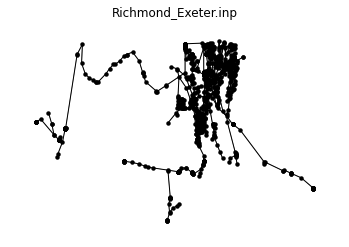

<AxesSubplot:title={'center':'Richmond_Exeter.inp'}>

In [3]:
# Acessando inp


nome_arquivo = 'Richmond(Vieira ok).inp' # .inp em litros/segundo

wn = wntr.network.WaterNetworkModel(nome_arquivo)

# Desenho da rede
wntr.graphics.plot_network(wn, title=wn.name)

In [4]:
# Duração total do período de simulação
T = range(1, 25)
print("Períodos =", list(T))
    
# Número de horas em cada período (1h)
Nh = (wn.options.time.pattern_timestep) / 3600 
print("Números de horas de cada período =", Nh) 

Períodos = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
Números de horas de cada período = 1.0


In [5]:
# NÓS

# Nós
N = wn.node_name_list  
print("N =", N) 

# Nós que são fontes
F = wn.reservoir_name_list                                         
print("F =", F) 

# Nós que são reservátorios
R = wn.tank_name_list 
print("R =", R) 

# Nós que são junções
J = []
for node, no in wn.nodes():
        if no.name not in F:
            if no.name not in R:
                J.append(no.name)
print("J =", J)

N = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158

In [6]:
# ARCOS

# Arcos
#A = []
#for link_name in wn.link_name_list:
#    link = wn.get_link(link_name)
#    node1 = wn.get_node(link.start_node).name
#    node2 = wn.get_node(link.end_node).name
#    A.append((node1, node2))
#print("A =", A)

# Arcos que possuem bombas
B = []
for link, arco in wn.links():
    if arco.name in wn.pump_name_list:
        node1 = wn.get_node(arco.start_node).name
        node2 = wn.get_node(arco.end_node).name
        B.append((node1, node2))
print("B =", B)

# Arcos que possuem válvulas
V = []
for link, arco in wn.links():
    if arco.name in wn.valve_name_list:
        node1 = wn.get_node(arco.start_node).name
        node2 = wn.get_node(arco.end_node).name
        V.append((node1, node2))
print("V =", V)

# Arcos que atuam por gravidade (sem bombas e sem válvulas)
G = []
for link, arco in wn.links():
    if arco.name not in wn.pump_name_list and arco.name not in wn.valve_name_list:
        node1 = wn.get_node(arco.start_node).name
        node2 = wn.get_node(arco.end_node).name
        G.append((node1, node2))
        G.append((node2, node1)) #bidirecionais
print("G =", G)

# Criar o conjunto A como a união de G, B e V
A = set(B) | set(V) | set(G)
A = list(A)
print("A =", A)

B = [('2009', '2002'), ('1690', '1693'), ('1005', '186'), ('1250', '353'), ('1648', '636'), ('264', '1125'), ('1815', '749')]
V = [('1708', '670')]
G = [('2', '3'), ('3', '2'), ('2', '6'), ('6', '2'), ('1', '9'), ('9', '1'), ('3', '4'), ('4', '3'), ('4', '5'), ('5', '4'), ('4', '10'), ('10', '4'), ('5', '7'), ('7', '5'), ('7', '8'), ('8', '7'), ('7', '104'), ('104', '7'), ('9', '20'), ('20', '9'), ('10', '11'), ('11', '10'), ('11', '12'), ('12', '11'), ('12', '798'), ('798', '12'), ('798', '13'), ('13', '798'), ('12', '14'), ('14', '12'), ('13', '73'), ('73', '13'), ('14', '15'), ('15', '14'), ('14', '58'), ('58', '14'), ('15', '16'), ('16', '15'), ('16', '44'), ('44', '16'), ('17', '16'), ('16', '17'), ('17', '18'), ('18', '17'), ('18', '19'), ('19', '18'), ('19', '21'), ('21', '19'), ('19', '25'), ('25', '19'), ('21', '22'), ('22', '21'), ('21', '23'), ('23', '21'), ('20', '31'), ('31', '20'), ('23', '24'), ('24', '23'), ('24', '25'), ('25', '24'), ('24', '27'), ('27', '24'), ('25', 

In [7]:
# NÓ INICIAL E FINAL DE CADA ARCO

arcos = []
nos_iniciais = []
nos_finais = []

# Iterar sobre todos os arcos na rede
for link_name, link in wn.links():
    arcos.append(link_name)
    nos_iniciais.append(link.start_node)
    nos_finais.append(link.end_node)

data = {'Arco': arcos, 'Nó Inicial': nos_iniciais, 'Nó Final': nos_finais}
df = pd.DataFrame(data)
print(df)

      Arco Nó Inicial Nó Final
0      785          2        3
1      786          2        6
2      787          1        9
3      788          3        4
4      789          4        5
..     ...        ...      ...
952     4B       1250      353
953     5C       1648      636
954     6D        264     1125
955     7F       1815      749
956  v1708       1708      670

[957 rows x 3 columns]


In [8]:
# NÓS PREDECESSORES E SUCESSORES

# Criar um grafo direcionado a partir da rede EPANET
Graf = wn.get_graph()
# Adicionar arcos bidirecionais de G ao grafo
for (node1, node2) in G:
    Graf.add_edge(node1, node2)

# Nós predecessores
predecessors = {}
for node in Graf.nodes():
    P = [pred for pred in Graf.predecessors(node)]
    predecessors[node] = P
for node, P in predecessors.items():
    print(f"Nó: {node}, Predecessores: {P}")

# Nós sucessores
successors = {}
for node in Graf.nodes():
    S = [succ for succ in Graf.successors(node)]
    successors[node] = S
for node, S in successors.items():
    print(f"Nó: {node}, Sucessores: {S}")

Nó: 1, Predecessores: ['771', '9']
Nó: 2, Predecessores: ['318', '3', '6']
Nó: 3, Predecessores: ['2', '4']
Nó: 4, Predecessores: ['3', '5', '10']
Nó: 5, Predecessores: ['4', '7']
Nó: 6, Predecessores: ['2']
Nó: 7, Predecessores: ['5', '8', '104']
Nó: 8, Predecessores: ['7']
Nó: 9, Predecessores: ['1', '20']
Nó: 10, Predecessores: ['4', '11']
Nó: 11, Predecessores: ['10', '12']
Nó: 12, Predecessores: ['11', '798', '14']
Nó: 13, Predecessores: ['798', '69', '73']
Nó: 14, Predecessores: ['12', '15', '58']
Nó: 15, Predecessores: ['14', '16']
Nó: 16, Predecessores: ['15', '17', '44']
Nó: 17, Predecessores: ['16', '18']
Nó: 18, Predecessores: ['17', '19']
Nó: 19, Predecessores: ['18', '21', '25']
Nó: 20, Predecessores: ['9', '31']
Nó: 21, Predecessores: ['19', '22', '23']
Nó: 22, Predecessores: ['21']
Nó: 23, Predecessores: ['21', '24']
Nó: 24, Predecessores: ['23', '25', '27']
Nó: 25, Predecessores: ['19', '24', '26']
Nó: 26, Predecessores: ['25', '27', '29']
Nó: 27, Predecessores: ['24', 

C:\Users\lemiq\AppData\Local\Temp/ipykernel_8324/729179350.py:4: DeprecationWarning: wntr.network.WaterNetworkModel.get_graph is deprecated, use wntr.network.WaterNetworkModel.to_graph instead
  Graf = wn.get_graph()


Nó: 540, Sucessores: ['538', '539']
Nó: 541, Sucessores: ['542', '508']
Nó: 542, Sucessores: ['543', '541']
Nó: 543, Sucessores: ['544', '506', '542']
Nó: 544, Sucessores: ['545', '543']
Nó: 545, Sucessores: ['546', '562', '544']
Nó: 546, Sucessores: ['547', '560', '545']
Nó: 547, Sucessores: ['548', '549', '546']
Nó: 548, Sucessores: ['547', '549']
Nó: 549, Sucessores: ['548', '550', '547']
Nó: 550, Sucessores: ['551', '552', '549']
Nó: 551, Sucessores: ['552', '550']
Nó: 552, Sucessores: ['553', '550', '551']
Nó: 553, Sucessores: ['554', '559', '552']
Nó: 554, Sucessores: ['555', '557', '553']
Nó: 555, Sucessores: ['556', '554']
Nó: 556, Sucessores: ['555']
Nó: 557, Sucessores: ['558', '554']
Nó: 558, Sucessores: ['557']
Nó: 559, Sucessores: ['560', '553']
Nó: 560, Sucessores: ['561', '546', '559']
Nó: 561, Sucessores: ['562', '563', '560']
Nó: 562, Sucessores: ['585', '545', '561']
Nó: 563, Sucessores: ['564', '567', '561']
Nó: 564, Sucessores: ['565', '573', '563']
Nó: 565, Sucesso

In [9]:
# CUSTO DE FUNCIONAMENTO DAS BOMBAS

# Lê tarifas
def read_pump_tariffs(nome_arquivo):
    tarifa = {}
    in_patterns_block = False
    with open(nome_arquivo, 'r') as f:
        for line in f:
            line = line.strip()
            if in_patterns_block:
                if line.startswith('CBTariff'): 
                    matches = re.findall(r'\b\d+\.\d+\b', line)
                    if matches:
                        tarifa.setdefault("CBTariff", []).extend(float(match) for match in matches) 
                if line.startswith('STTariff'): 
                    matches = re.findall(r'\b\d+\.\d+\b', line)
                    if matches:
                        tarifa.setdefault("STTariff", []).extend(float(match) for match in matches)
                if line.startswith('LZHZTariff'): 
                    matches = re.findall(r'\b\d+\.\d+\b', line)
                    if matches:
                        tarifa.setdefault("LZHZTariff", []).extend(float(match) for match in matches) 
                if line.startswith('HHTariff'): 
                    matches = re.findall(r'\b\d+\.\d+\b', line)
                    if matches:
                        tarifa.setdefault("HHTariff", []).extend(float(match) for match in matches) 
                if line.startswith('LZGTariff'): 
                    matches = re.findall(r'\b\d+\.\d+\b', line)
                    if matches:
                        tarifa.setdefault("LZGTariff", []).extend(float(match) for match in matches) 
                if line.startswith('STariff'): 
                    matches = re.findall(r'\b\d+\.\d+\b', line)
                    if matches:
                        tarifa.setdefault("STariff", []).extend(float(match) for match in matches) 
            elif line == '[PATTERNS]':
                in_patterns_block = True
    return tarifa
tarifa = read_pump_tariffs(nome_arquivo)
df = pd.DataFrame(tarifa)
print(df)

c = {}

# Iterar sobre cada arco de B
node1 = {}
node2 = {}

for node1, node2 in B: #1A B1
    arco = ('2009', '2002')  
    for t, custo in enumerate(tarifa.get("CBTariff", []), start=1): 
        c[(arco, t)] = custo
        
for node1, node2 in B: #2A B5
    arco = ('1690', '1693')  
    for t, custo in enumerate(tarifa.get("CBTariff", []), start=1): 
        c[(arco, t)] = custo
        
for node1, node2 in B: #3A B6
    arco = ('1005', '186')  
    for t, custo in enumerate(tarifa.get("STTariff", []), start=1): 
        c[(arco, t)] = custo
        
for node1, node2 in B: #4B B4
    arco = ('1250', '353')  
    for t, custo in enumerate(tarifa.get("LZHZTariff", []), start=1): 
        c[(arco, t)] = custo
        
for node1, node2 in B: #5C B2
    arco = ('1648', '636')  
    for t, custo in enumerate(tarifa.get("HHTariff", []), start=1): 
        c[(arco, t)] = custo
        
for node1, node2 in B: #6D B7
    arco = ('264', '1125')  
    for t, custo in enumerate(tarifa.get("LZGTariff", []), start=1): 
        c[(arco, t)] = custo
        
for node1, node2 in B: #7F B3
    arco = ('1815', '749')  
    for t, custo in enumerate(tarifa.get("STariff", []), start=1): 
        c[(arco, t)] = custo

print("Custos por arco e período:", c)

    CBTariff  HHTariff  LZGTariff  LZHZTariff  STariff  STTariff
0   0.024093   0.02460    0.02460    0.024567   0.0244   0.02410
1   0.024093   0.02460    0.02460    0.024567   0.0244   0.02410
2   0.024093   0.02460    0.02460    0.024567   0.0244   0.02410
3   0.024093   0.02460    0.02460    0.024567   0.0244   0.02410
4   0.024093   0.02460    0.02460    0.024567   0.0244   0.02410
5   0.024093   0.02460    0.02460    0.024567   0.0244   0.02410
6   0.024093   0.02460    0.02460    0.024567   0.0244   0.02410
7   0.067945   0.09866    0.11195    0.123400   0.1194   0.07535
8   0.067945   0.09866    0.11195    0.123400   0.1194   0.07535
9   0.067945   0.09866    0.11195    0.123400   0.1194   0.07535
10  0.067945   0.09866    0.11195    0.123400   0.1194   0.07535
11  0.067945   0.09866    0.11195    0.123400   0.1194   0.07535
12  0.067945   0.09866    0.11195    0.123400   0.1194   0.07535
13  0.067945   0.09866    0.11195    0.123400   0.1194   0.07535
14  0.067945   0.09866   

In [10]:
# DEMANDA POR PERÍODO
# Richmond transforma litros por segundo em m3/segundo
# Obs.: a rede possui múltiplas categorias de consumo aos nós

# Encontra os nós com demanda positiva na seção 
def find_nodes_with_demand(nome_arquivo):
    nodes_with_demand = {}
    in_junctions_section = False
    with open(nome_arquivo, 'r') as f:
        for line in f:
            line = line.strip()
            if in_junctions_section:
                if line.startswith('['):
                    break
                elif line and not line.startswith(';'):
                    parts = line.split()
                    node_id = parts[0]
                    demand = float(parts[2])
                    if demand > 0:
                        pattern = parts[3] if len(parts) > 3 else "None"
                        nodes_with_demand[node_id] = {'demand': demand, 'pattern': pattern}
            elif line == '[JUNCTIONS]':
                in_junctions_section = True
    return nodes_with_demand

# Lê a seção [DEMANDS]
def read_demand_section(nome_arquivo):
    additional_demands = {}
    in_demands_section = False
    with open(nome_arquivo, 'r') as f:
        for line in f:
            line = line.strip()
            if in_demands_section:
                if line.startswith('['):
                    break
                elif line and not line.startswith(';'):
                    parts = line.split()
                    node_id = parts[0]
                    demand = float(parts[1])
                    pattern = parts[2] if len(parts) > 2 else "None"
                    if node_id in additional_demands:
                        additional_demands[node_id].append({'demand': demand, 'pattern': pattern})
                    else:
                        additional_demands[node_id] = [{'demand': demand, 'pattern': pattern}]
            elif line == '[DEMANDS]':
                in_demands_section = True
    return additional_demands

# Lê os padrões de demanda na seção [PATTERNS]
def read_demand_patterns(nome_arquivo):
    demand_patterns = {}
    in_patterns_section = False
    current_pattern = None  
    with open(nome_arquivo, 'r') as f:
        for line in f:
            line = line.strip()
            if in_patterns_section:
                if line.startswith('['):
                    break
                elif line and not line.startswith(';'):
                    parts = line.split()
                    pattern_id = parts[0]
                    pattern_values = [float(val) for val in parts[1:]]
                    # Preencher os valores do padrão até 24 horas
                    while len(pattern_values) < 24:
                        pattern_values.extend(pattern_values)
                    demand_patterns[pattern_id] = pattern_values[:24]
            elif line == '[PATTERNS]':
                in_patterns_section = True            
    return demand_patterns

# Calcula a demanda a cada período através do padrão
def calculate_demand_per_period(nodes_with_demand, additional_demands, demand_patterns):
    demand_per_period = {}
    for node, data in nodes_with_demand.items():
        pattern = data['pattern']
        demand = data['demand']
        pattern_values = demand_patterns.get(pattern)
        if pattern_values:
            # Repetir os valores do padrão para 24 horas
            repeated_pattern_values = pattern_values * (24 // len(pattern_values))
            # Converter de litros por segundo para metros cúbicos por hora
            demand_per_period[node] = [demand * value * 3.6 for value in repeated_pattern_values]
        else:
            # Caso não haja padrão, preenche com a demanda constante
            demand_per_period[node] = [demand * 3.6] * 24
    
    # Adiciona demandas da seção [DEMANDS]
    for node, demands in additional_demands.items():
        if node not in demand_per_period:
            demand_per_period[node] = [0] * 24
        for demand_info in demands:
            demand = demand_info['demand']
            pattern = demand_info['pattern']
            pattern_values = demand_patterns.get(pattern)
            if pattern_values:
                repeated_pattern_values = pattern_values * (24 // len(pattern_values))
                additional_demand_values = [demand * value * 3.6 for value in repeated_pattern_values]
            else:
                additional_demand_values = [demand * 3.6] * 24
            # Soma as demandas adicionais
            demand_per_period[node] = [demand_per_period[node][i] + additional_demand_values[i] for i in range(24)]
    
    return demand_per_period

# Executa as funções
nodes_with_demand = find_nodes_with_demand(nome_arquivo)
additional_demands = read_demand_section(nome_arquivo)
demand_patterns = read_demand_patterns(nome_arquivo)
demand_per_period = calculate_demand_per_period(nodes_with_demand, additional_demands, demand_patterns)

d = {'Nó': [], 'Período': [], 'Demanda': []}
for node, demand_values in demand_per_period.items():
    for periodo, valor in enumerate(demand_values, start=1):
        d['Nó'].append(node)
        d['Período'].append(periodo)
        d['Demanda'].append(valor)

df = pd.DataFrame(d)
#print(df.to_string(index=False))

demand_dict = {(row['Nó'], row['Período']): row['Demanda'] for index, row in df.iterrows()}

print("\nDicionário demand_dict:")
for key, value in demand_dict.items():
    print(f"{key}: {value}")


Dicionário demand_dict:
('1', 1): 0.0036000000000000003
('1', 2): 0.0036000000000000003
('1', 3): 0.0036000000000000003
('1', 4): 0.0036000000000000003
('1', 5): 0.0036000000000000003
('1', 6): 0.0036000000000000003
('1', 7): 0.0036000000000000003
('1', 8): 0.0036000000000000003
('1', 9): 0.0036000000000000003
('1', 10): 0.0036000000000000003
('1', 11): 0.0036000000000000003
('1', 12): 0.0036000000000000003
('1', 13): 0.0036000000000000003
('1', 14): 0.0036000000000000003
('1', 15): 0.0036000000000000003
('1', 16): 0.0036000000000000003
('1', 17): 0.0036000000000000003
('1', 18): 0.0036000000000000003
('1', 19): 0.0036000000000000003
('1', 20): 0.0036000000000000003
('1', 21): 0.0036000000000000003
('1', 22): 0.0036000000000000003
('1', 23): 0.0036000000000000003
('1', 24): 0.0036000000000000003
('9', 1): 0.6408
('9', 2): 0.6408
('9', 3): 0.6408
('9', 4): 0.6408
('9', 5): 0.6408
('9', 6): 0.6408
('9', 7): 0.6408
('9', 8): 0.6408
('9', 9): 0.6408
('9', 10): 0.6408
('9', 11): 0.6408
('9

In [11]:
# VOLUMES MAX, MIN E INICIAL DOS RESERVATÓRIOS

# Richmond já estão em metros cúbicos, pois no .inp os valores para o diâmetro do reservatório e a altura estão em metros

def find_tanks(nome_arquivo):
    tanks = {}
    H_0 = {}  
    H_min = {}  
    H_max = {}  
    in_tanks_section = False
    with open(nome_arquivo, 'r') as f:
        for line in f:
            line = line.strip()
            if in_tanks_section:
                if line.startswith('['):
                    break
                elif line and not line.startswith(';'):
                    parts = line.split()
                    tank_id = parts[0]
                    elevation = float(parts[1])
                    min_level = float(parts[3])
                    max_level = float(parts[4])
                    diameter = float(parts[5])
                    initial_level = float(parts[2])
                    # Volume do cilindro
                    initial_volume = ((initial_level - min_level) / (max_level - min_level)) * ((3.14159 * diameter**2) / 4)
                    tanks[tank_id] = {'elevation': elevation, 'min_level': min_level, 'max_level': max_level, 'diameter': diameter}
                    H_0[tank_id] = initial_volume 
                    #H_min[tank_id] = ((min_level - min_level) / (max_level - min_level)) * ((3.14159 * diameter**2) / 4)  
                    H_max[tank_id] = ((max_level - min_level) / (max_level - min_level)) * ((3.14159 * diameter**2) / 4)  
                    H_min[tank_id] = 0.25 * H_max[tank_id]
            elif line == '[TANKS]':
                in_tanks_section = True
    return tanks, H_0, H_min, H_max

tanks, H_0, H_min, H_max = find_tanks(nome_arquivo)

for tank_id, initial_volume in H_0.items():
    print(f"ID: {tank_id}, Volume Inicial: {H_0[tank_id]}, Volume Mínimo: {H_min[tank_id]}, Volume Máximo: {H_max[tank_id]}")

ID: A, Volume Inicial: 401.55952535608304, Volume Mínimo: 108.43394234374999, Volume Máximo: 433.73576937499996
ID: B, Volume Inicial: 171.976059070411, Volume Mínimo: 46.566217775000005, Volume Máximo: 186.26487110000002
ID: C, Volume Inicial: 31.474961891999993, Volume Mínimo: 8.552978774999998, Volume Máximo: 34.21191509999999
ID: D, Volume Inicial: 100.54785351943129, Volume Mínimo: 27.339686975, Volume Máximo: 109.3587479
ID: E, Volume Inicial: 46.15451182156134, Volume Mínimo: 12.56636, Volume Máximo: 50.26544
ID: F, Volume Inicial: 9.10975029041096, Volume Mínimo: 2.5446879, Volume Máximo: 10.1787516


In [12]:
# VAZÃO MÁXIMA - bombas e tubulações
# rendimento da bomba em 75%
# já está em metros cúbicos por hora

v = {}

for link_name in wn.link_name_list:
    link = wn.get_link(link_name)
    # Link sem bomba
    if isinstance(link, wntr.network.elements.Pipe):
        diametro = link.diameter
        vazao = (math.pi * (diametro ** 2) * 3600 * 3) / 4 # Calcula a vazão em metros cúbicos por hora
        no_inicial = wn.get_node(link.start_node).name
        no_final = wn.get_node(link.end_node).name
        v[(no_inicial, no_final)] = vazao
        v[(no_final, no_inicial)] = vazao  # Adiciona o arco bidirecional
   
    # Link com bomba
        # Vazão com rendimento da bomba em 75%
        v[('2009', '2002')] = 144 #1A
        v[('1690', '1693')] = 162 #2A
        v[('1005', '186')] = 245 #3A
        v[('1250', '353') ] = 260 #4B
        v[('1648', '636')] = 17 #5C
        v[('264', '1125')] = 40 #6D
        v[('1815', '749')] = 20 #7E

for (no_inicial, no_final), vazao in v.items():
    print(f"Link: ({no_inicial}, {no_final}), Vazão: {vazao:.2f} metros cúbicos por hora.")

Link: (2, 3), Vazão: 190.85 metros cúbicos por hora.
Link: (3, 2), Vazão: 190.85 metros cúbicos por hora.
Link: (2009, 2002), Vazão: 144.00 metros cúbicos por hora.
Link: (1690, 1693), Vazão: 162.00 metros cúbicos por hora.
Link: (1005, 186), Vazão: 245.00 metros cúbicos por hora.
Link: (1250, 353), Vazão: 260.00 metros cúbicos por hora.
Link: (1648, 636), Vazão: 17.00 metros cúbicos por hora.
Link: (264, 1125), Vazão: 40.00 metros cúbicos por hora.
Link: (1815, 749), Vazão: 20.00 metros cúbicos por hora.
Link: (2, 6), Vazão: 190.85 metros cúbicos por hora.
Link: (6, 2), Vazão: 190.85 metros cúbicos por hora.
Link: (1, 9), Vazão: 190.85 metros cúbicos por hora.
Link: (9, 1), Vazão: 190.85 metros cúbicos por hora.
Link: (3, 4), Vazão: 190.85 metros cúbicos por hora.
Link: (4, 3), Vazão: 190.85 metros cúbicos por hora.
Link: (4, 5), Vazão: 190.85 metros cúbicos por hora.
Link: (5, 4), Vazão: 190.85 metros cúbicos por hora.
Link: (4, 10), Vazão: 190.85 metros cúbicos por hora.
Link: (10, 

### 1.2.2 Demais dados

In [13]:
ca = 0.1 * 0.1234 # custo de acionamento das bombas - utilizando 10% do maior custo do arquivo inp
penalidade = 0.1*0.1234
Theta = 0  # perda de água por período (em %)

#### Calculando a nova ordem dos índices

In [14]:
T_reordered_indices = [(tempo + 7) % 24 for tempo in range(24)]
print("Períodos ordenados =", list(T_reordered_indices))

Períodos ordenados = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6]


## 1.3 Modelo matemático

In [15]:
m = gp.Model()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-20


In [16]:
# VARIÁVEIS

x = m.addVars(A, T, vtype=gp.GRB.CONTINUOUS, name="x")  # fração do período em que há fluxo no arco
for (i, j) in A:
   x[i, j, 0] = 1

e = m.addVars(R, T, vtype=gp.GRB.CONTINUOUS, name="e") # estoque de água nos reservatórios


alpha = m.addVars(A, T, vtype=gp.GRB.BINARY, name="alpha") # se há fluxo no arco no período
for (i, j) in A:
   alpha[i, j, 0] = 1


l = m.addVars(B, T, vtype=gp.GRB.BINARY, name="l") # se a bomba do arco foi acionada no período
for (i, j) in B:
    l[i, j, 0] = 1

psipos = m.addVars(J, T, vtype=gp.GRB.CONTINUOUS, name="psipos") # excesso de demanda
psineg = m.addVars(J, T, vtype=gp.GRB.CONTINUOUS, name="psineg") # falta de demanda

In [17]:
# FUNÇÃO OBJETIVO

m.setObjective((gp.quicksum(x[i, j, T_reordered_indices[t] + 1] * c[(i, j), T_reordered_indices[t] + 1] + l[i, j, T_reordered_indices[t] + 1] * ca + alpha[i, j, T_reordered_indices[t] + 1] for (i, j) in B for t in range(24)))
                + gp.quicksum(psipos[i, T_reordered_indices[t] + 1] * penalidade + psineg[i, T_reordered_indices[t] + 1] * penalidade for i in J for t in range(24)), sense=gp.GRB.MINIMIZE)

In [18]:
# RESTRIÇÕES

In [19]:
# 1: balancemento de estoque de água em nós com reservatório                 

# Restrição para t1 (início no período 7 original)
r1_t1 = m.addConstrs(
    (e[i, T_reordered_indices[0] + 1] == H_0[i] 
    + gp.quicksum((1 - Theta) * (v[k, i] * x[k, i, T_reordered_indices[0] + 1]) for k in predecessors.get(i, []))
    - gp.quicksum((1 - Theta) * (v[i, j] * x[i, j, T_reordered_indices[0] + 1]) for j in successors.get(i, [])))
    for i in R
)

# Restrição para t > 1 (períodos subsequentes)
r1 = m.addConstrs(
    (e[i, T_reordered_indices[t] + 1] == e[i, T_reordered_indices[t - 1] + 1]  
    + gp.quicksum((1 - Theta) * (v[k, i] * x[k, i, T_reordered_indices[t] + 1]) for k in predecessors.get(i, []))
    - gp.quicksum((1 - Theta) * (v[i, j] * x[i, j, T_reordered_indices[t] + 1]) for j in successors.get(i, [])))
    for i in R for t in range(1, 24)
)

In [20]:
# 2: balanceamento de demanda

for i in J:
    for t in T:
        if (i, t) not in demand_dict:
            demand_dict[(i, t)] = 0  # Adiciona 0 onde não tem a demanda no dicionário d

r2 = m.addConstrs(
    (demand_dict[(i, T_reordered_indices[t] + 1)] + psipos[i, T_reordered_indices[t] + 1] - psineg[i, T_reordered_indices[t] + 1] ==
     gp.quicksum((1 - Theta) * v[k, i] * x.get((k, i, T_reordered_indices[t] + 1), 0)
    for k in predecessors.get(i, [])
                 if (k, i) not in V)  # Excluir arcos válvulas
     - gp.quicksum((1 - Theta) * v[i, j] * x.get((i, j, T_reordered_indices[t] + 1), 0)
    for j in successors.get(i, [])
                   if (i, j) not in V))  # Excluir arcos válvulas
    for i in J for t in range(24))

rdemanda = m.addConstrs(psipos[i, T_reordered_indices[t] + 1] >= 0 for i in J for t in range(24))
rdemanda2 = m.addConstrs(psineg[i, T_reordered_indices[t] + 1] >= 0 for i in J for t in range(24))

In [21]:
# 3: pode haver fluxo no arco uma fração do período      

r3_1 = m.addConstrs(x[i, j, T_reordered_indices[t] + 1] >= 0 for (i, j) in A for t in range(24))
r3_2 = m.addConstrs(x[i, j, T_reordered_indices[t] + 1] <= 1 for (i, j) in A for t in range(24))

In [22]:
# 4: controle a variável binária     

r4 = m.addConstrs(x[i, j, T_reordered_indices[t] + 1] <= alpha[i, j, T_reordered_indices[t] + 1] for (i, j) in A for t in range(24))


In [23]:
# 5: quando a bomba é acionada   

# Para t = 1 (usando o primeiro índice reordenado)
r5_t1 = m.addConstrs(
    l[i, j, T_reordered_indices[0] + 1] >= alpha[i, j, T_reordered_indices[0] + 1] - alpha[i, j, T_reordered_indices[0]]
    for (i, j) in B
)

# Para t > 1 (usando os índices reordenados)
r5 = m.addConstrs(
    l[i, j, T_reordered_indices[t] + 1] >= alpha[i, j, T_reordered_indices[t] + 1] - alpha[i, j, T_reordered_indices[t]]
    for (i, j) in B for t in range(1, 24)
)


In [24]:
# 6: volume min e máx dos reservatórios

r7_1 = m.addConstrs(
    H_min[i] <= e[i, T_reordered_indices[t] + 1]
    for i in R for t in range(24)
)

r7_2 = m.addConstrs(
    e[i, T_reordered_indices[t] + 1] <= H_max[i]
    for i in R for t in range(24)
)

m.update()

# Verificar se há variáveis no modelo
if m.numvars > 0:
    print("O modelo contém variáveis.")
    # Exibir todas as variáveis
    for var in m.getVars():
        print(var.varName)
else:
    print("O modelo não contém variáveis.")

# Verificar se há restrições no modelo
if m.numConstrs > 0:
    print("O modelo contém restrições.")
    # Exibir todas as restrições
    for constr in m.getConstrs():
        print(constr.ConstrName)  # Nome da restrição
else:
    print("O modelo não contém restrições.")


### 1.3.1 Otimização

In [25]:
m.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 200112 rows, 133320 columns and 358475 nonzeros
Model fingerprint: 0x6964fa0c
Variable types: 87408 continuous, 45912 integer (45912 binary)
Coefficient statistics:
  Matrix range     [8e-03, 8e+03]
  Objective range  [1e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+02]
Found heuristic solution: objective 63.3822587
Presolve removed 186539 rows and 104274 columns
Presolve time: 0.84s
Presolved: 13573 rows, 29046 columns, 44958 nonzeros
Variable types: 28717 continuous, 329 integer (329 binary)

Root relaxation: objective 1.509243e+01, 16830 iterations, 0.36 seconds (0.09 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   15.09243    0   25   63.38226   15.09243  76.2%     -    1s


# Esse caso seja infactível

m.computeIIS()
m.write("rich.lp")  # Salva em um arquivo para análise

# Se da infactível, aparece quais restrições estão com problema
for constr in m.getConstrs():
    if constr.IISConstr:
        print(f"Constraint {constr.ConstrName} is infeasible")

In [26]:
# RESULTADO FO

if m.status == GRB.Status.OPTIMAL:
    print('FO:', m.objVal)

    
# RESULTADO PARA CADA VARIÁVEL 
# de forma separada para melhorara vizualição

x_var = []
e_var = []
alpha_var = []
l_var = []
psipos_var = []
psineg_var = []

for var in m.getVars():
    if 'x' in var.varName:
        x_var.append(var)
    elif 'e' in var.varName:
        e_var.append(var)
    elif 'alpha' in var.varName:
        alpha_var.append(var)
    elif 'l' in var.varName:
        l_var.append(var)
    elif 'psipos' in var.varName:
        psipos_var.append(var)
    elif 'psineg' in var.varName:
        psineg_var.append(var)

FO: 17.558933352254265


In [ ]:
print("Resultados para variáveis do tipo x:")
for var in x_var:
    print(var.varName, '= {}' .format(np.round(var.x, 3)))

Resultados para variáveis do tipo x:
x[745,746,1] = 0.0
x[745,746,2] = 0.0
x[745,746,3] = 0.0
x[745,746,4] = 0.0
x[745,746,5] = 0.0
x[745,746,6] = 0.0
x[745,746,7] = 0.0
x[745,746,8] = 0.0
x[745,746,9] = 0.0
x[745,746,10] = 0.0
x[745,746,11] = 0.0
x[745,746,12] = 0.0
x[745,746,13] = 0.0
x[745,746,14] = 0.0
x[745,746,15] = 0.0
x[745,746,16] = 0.0
x[745,746,17] = 0.0
x[745,746,18] = 0.0
x[745,746,19] = 0.0
x[745,746,20] = 0.0
x[745,746,21] = 0.0
x[745,746,22] = 0.0
x[745,746,23] = 0.0
x[745,746,24] = 0.0
x[766,768,1] = 0.0
x[766,768,2] = 0.0
x[766,768,3] = 0.0
x[766,768,4] = 0.0
x[766,768,5] = 0.0
x[766,768,6] = 0.0
x[766,768,7] = 0.0
x[766,768,8] = 0.0
x[766,768,9] = 0.0
x[766,768,10] = 0.0
x[766,768,11] = 0.0
x[766,768,12] = 0.0
x[766,768,13] = 0.0
x[766,768,14] = 0.0
x[766,768,15] = 0.0
x[766,768,16] = 0.0
x[766,768,17] = 0.0
x[766,768,18] = 0.0
x[766,768,19] = 0.0
x[766,768,20] = 0.0
x[766,768,21] = 0.0
x[766,768,22] = 0.0
x[766,768,23] = 0.0
x[766,768,24] = 0.0
x[427,428,1] = 0.0
x[

In [ ]:
print("\nResultados para variáveis do tipo e:")
for var in e_var:
    print(var.varName, '= {}' .format(np.round(var.x, 3)))

In [ ]:
print("\nResultados para variáveis do tipo alpha:")
for var in alpha_var:
    print(var.varName, '= {}' .format(np.round(var.x, 3)))

In [ ]:
print("\nResultados para variáveis do tipo l:")
for var in l_var:
    print(var.varName, '= {}' .format(np.round(var.x, 3)))

In [ ]:
print("\nResultados para variáveis do tipo psipos:")
for var in psipos_var:
    print(var.varName, '= {}' .format(np.round(var.x, 100)))
    
print("\nResultados para variáveis do tipo psineg:")
for var in psineg_var:
    print(var.varName, '= {}' .format(np.round(var.x, 100)))

In [ ]:
# Esse quando a otimização está OK

# Exeter
m.write("rich_exeter.lp")  # Salva em um arquivo para análise

# Vieira
#m.write("rich_vieira.lp")  # Salva em um arquivo para análise

In [ ]:
# Função para obter os valores de alpha das bombas (quando as bombas estão funcionando)
def criar_dataframe_alpha(alpha, B, T):
    T = [0] + list(T)  # Converte range para lista e adiciona 0 no início
    
    alpha_bomba = pd.DataFrame(index=T)
    for node1, node2 in B:
        aux = [1]  # Define o valor para o período 0 como 1
        for t in T[1:]:  # Itera a partir do período 1
            value = round(alpha[(node1, node2, t)].x)
            value = max(0, min(1, value))  # Mantém entre 0 e 1
            aux.append(value)  # Adiciona o valor otimizado
        df_temp = pd.DataFrame(np.array(aux).reshape(-1, 1), columns=[(node1, node2)])
        alpha_bomba = pd.concat([alpha_bomba, df_temp], axis=1)
    
    return alpha_bomba

# Exemplo de uso
alpha_bomba = criar_dataframe_alpha(alpha, B, T)
print(alpha_bomba)

## 1.4 Simulação Epanet

### 1.4.1 Rede

In [ ]:
# Define litros/segundo, hazen-willians, e simulação iniciando ás 7am
# Características do VanZyl

wn.options.hydraulic.inpfile_units = 'LPS'
wn.options.hydraulic.headloss = 'H-W'
wn.options.time.start_clocktime = 7.0

num_dia = 1 # quantidade de dias
wn.options.time.duration = num_dia * 24 * 60 * 60

### 1.4.2 Adição de controles do modelo de otimização e Simulação

In [ ]:
# Redefinir o modelo de rede de água
wn.reset_initial_values() 

In [ ]:
# Dicionário que mapeia os pares de nós para os nomes dos links

link_names = {}
for link, arco in wn.links():
    if arco.name in wn.pump_name_list:
        node1 = wn.get_node(arco.start_node).name
        node2 = wn.get_node(arco.end_node).name
        link_names[(node1, node2)] = arco.name
print("Link Names =", link_names)

In [ ]:
# ADD CONTROLES
# de acordo com valores do alpha
# 0 da otimização é 7 no controle para o Epanet no VanZyl (mas 0 nos resultados), aqui ja sai transformado

def horas(number):
    return str(number).zfill(2) + ':00:00'

def ajustar_tempo_para_7am(t):
    # Ajusta o tempo de 0-24h para 7am do dia atual até 6am do dia seguinte,
    # pois simulação no VanZyl inicia às 7am
    adjusted_time = (t + 7) % 25
    return adjusted_time

def criar_controles(wn, alpha_bomba, T, link_names):
    pump_data = []
    for col in alpha_bomba.columns:
        pump_data.append({
            "name": link_names[col],
            "time": np.array([ajustar_tempo_para_7am(t) for t in range(len(T)+1)]),
            "status": alpha_bomba[col].values
        })

    for dct in pump_data:
        for idx, valor in enumerate(dct['time']):
            link_name = dct['name']
            hora = horas(valor)
            ctrl = controls.Control(
                controls.SimTimeCondition(wn, '=', hora),  # condição
                controls.ControlAction(wn.get_link(link_name), 'status', dct['status'][idx]),  # ação
                name=link_name + '_' + str(idx + 1)  # nome do controle
            )
            wn.add_control(link_name + '_' + str(idx + 1), ctrl)  # adicionar controle
            print(ctrl)

# Exemplo de uso
criar_controles(wn, alpha_bomba, T, link_names)

In [ ]:
# PARA COPIAR E COLAR OS CONTROLES DIRETO PRO EPANET
# 0 da simulação é 7 no controle para o Epanet no VanZyl (mas 0 nos resultados), aqui ja sai transformado

# Formata as horas no formato EPANET (24 horas)
def format_time_epanet(hour, minute, second):
    return f"{hour:02d}:{minute:02d}:{second:02d}"

# Ajusta o tempo para iniciar às 7 am
def ajustar_tempo_para_7am(t):
    # Ajusta o tempo de 0-24h para 7am do dia atual até 6am do dia seguinte
    adjusted_time = (t + 7) % 25
    return adjusted_time

# Criar os controles no formato EPANET
def criar_controles_epanet(wn, alpha_bomba, T, link_names):
    controls_epanet = []
    
    for col in alpha_bomba.columns:
        pump_name = link_names[col]  # Nome da bomba no arquivo .inp
        pump_controls = []
        previous_status = None
        previous_time_str = None
        for t in range(len(T) + 1):
            status = 'OPEN' if alpha_bomba.at[t, col] == 1 else 'CLOSED'
            hour = ajustar_tempo_para_7am(int(t) % 25)  # Ajusta o tempo para iniciar às 7am
            minute = int((t % 1) * 60)  # Converte o tempo para minutos
            second = 0  # Define os segundos como 0
            time_str = format_time_epanet(hour, minute, second)
            if status != previous_status or time_str != previous_time_str:
                if previous_status is not None:
                    control_str = f"PUMP {pump_name} {previous_status} AT CLOCKTIME {previous_time_str}"
                    pump_controls.append(control_str)
                previous_status = status
                previous_time_str = time_str
            if t == len(T):  # Ajusta para garantir que o último tempo seja incluído
                control_str = f"PUMP {pump_name} {status} AT CLOCKTIME {time_str}"
                pump_controls.append(control_str)
        
        # Ordena os controles para a bomba 
        pump_controls.sort(key=lambda x: int(x.split()[5].split(':')[0]) * 3600 + int(x.split()[5].split(':')[1]) * 60 + int(x.split()[5].split(':')[2]))
        controls_epanet.extend(pump_controls)
    
    return controls_epanet

# Exemplo de uso com os dados wn, alpha_bomba, T, link_names já definidos
controls_epanet = criar_controles_epanet(wn, alpha_bomba, T, link_names)

# Imprime os controles formatados para o EPANET
for control in controls_epanet:
    print(control)

In [ ]:
# QUANTIDADE DE ELEMENTOS
tipos = wn.node_name_list
quantidade = wn.num_nodes
wn.describe(level=0)

In [ ]:
# SIMULAÇÃO HIDRÁULICA
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()

### 1.4.3 Nós com pressão negativa

In [ ]:
demanda = results.node['demand'].loc[:,wn.junction_name_list].min()
pressao = results.node['pressure'].loc[:,wn.junction_name_list].min()

# Nós com demanda positiva e pressão negativa
for x in set(demanda[demanda > 0].index): 
    if x in set(pressao[pressao < 0].index):
        nos_neg = results.node['pressure'].loc[results.node['pressure'].loc[:, x] < 0, x].copy(deep=False)
        nos_neg.index /= 3600
        print(nos_neg)